<a href="https://colab.research.google.com/github/Miqoilla/Telco-Customer-Churn-Analysis/blob/main/Customer_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Prediksi Customer Churn - Telekomunikasi

Dataset: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

Tujuan: Memprediksi customer yang akan churn menggunakan machine learning

In [2]:
# import library yang dibutuhin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load Dataset

In [3]:
# baca dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"Jumlah data: {df.shape}")
df.head()

Jumlah data: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Profile Dataset

In [4]:
# cek info dataset
print("Info Dataset:")
print(df.info())
print("\n" + "="*50)

# statistik deskriptif
print("\nStatistik Deskriptif:")
print(df.describe())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

In [5]:
# cek missing values
print("Missing Values:")
print(df.isnull().sum())

# cek duplikat
print(f"\nDuplikasi data: {df.duplicated().sum()}")

Missing Values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Duplikasi data: 0


In [6]:
# cek distribusi target
print("Distribusi Churn:")
print(df['Churn'].value_counts())
print("\nPersentase:")
print(df['Churn'].value_counts(normalize=True)*100)

Distribusi Churn:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Persentase:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


## 2. Data Preprocessing

In [7]:
# copy dataset buat di proses
data = df.copy()

# TotalCharges ada yang kosong (spasi), jadi perlu dibenerin
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

print(f"Missing values di TotalCharges: {data['TotalCharges'].isnull().sum()}")

# isi missing value pake median
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# customerID ga penting, di drop aja
data.drop('customerID', axis=1, inplace=True)

print(f"\nShape setelah cleaning: {data.shape}")

Missing values di TotalCharges: 11

Shape setelah cleaning: (7043, 20)


In [8]:
# encoding target (Churn)
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

# list categorical columns
cat_cols = data.select_dtypes(include='object').columns.tolist()
print(f"Categorical columns: {len(cat_cols)}")
print(cat_cols)

Categorical columns: 15
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [9]:
# encoding untuk binary columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in binary_cols:
    if col in data.columns:
        data[col] = data[col].map({data[col].unique()[0]: 0, data[col].unique()[1]: 1})

print("Binary encoding done")

Binary encoding done


In [10]:
# one-hot encoding buat categorical lainnya
multi_cat = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
             'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
             'Contract', 'PaymentMethod']

data = pd.get_dummies(data, columns=multi_cat, drop_first=True)

print(f"Shape after encoding: {data.shape}")
print(f"\nColumns: {len(data.columns)}")

Shape after encoding: (7043, 31)

Columns: 31


In [11]:
# split features dan target
X = data.drop('Churn', axis=1)
y = data['Churn']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")
print(f"\nChurn distribution:")
print(y.value_counts())

Features: (7043, 30)
Target: (7043,)

Churn distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64


In [12]:
# scaling numerical features
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

print("Scaling done")

Scaling done


In [13]:
# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"\nTrain target:")
print(y_train.value_counts())

Train: (5634, 30)
Test: (1409, 30)

Train target:
Churn
0    4139
1    1495
Name: count, dtype: int64


In [14]:
# handle imbalanced class pake SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_sm.value_counts())

Before SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

After SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64


## 3. Exploratory Data Analysis

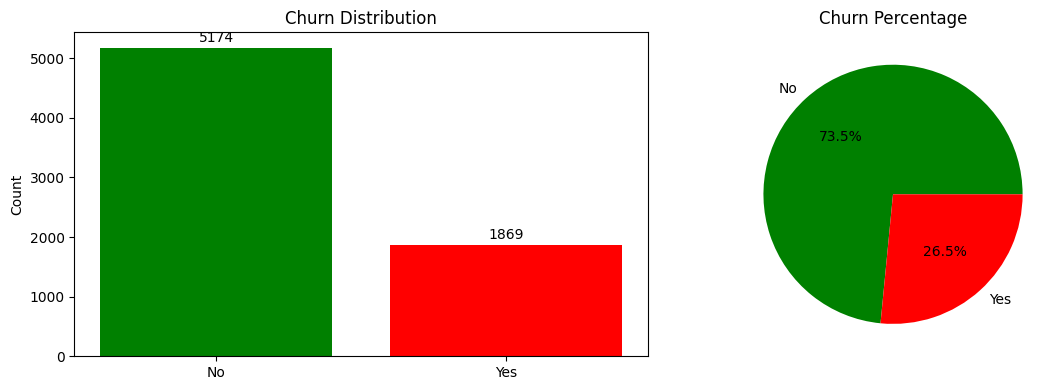

In [15]:
# plot distribusi churn
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# countplot
churn_count = df['Churn'].value_counts()
ax[0].bar(['No', 'Yes'], churn_count.values, color=['green', 'red'])
ax[0].set_title('Churn Distribution')
ax[0].set_ylabel('Count')
for i, v in enumerate(churn_count.values):
    ax[0].text(i, v+100, str(v), ha='center')

# pie chart
ax[1].pie(churn_count.values, labels=['No', 'Yes'], autopct='%1.1f%%', colors=['green', 'red'])
ax[1].set_title('Churn Percentage')

plt.tight_layout()
plt.show()

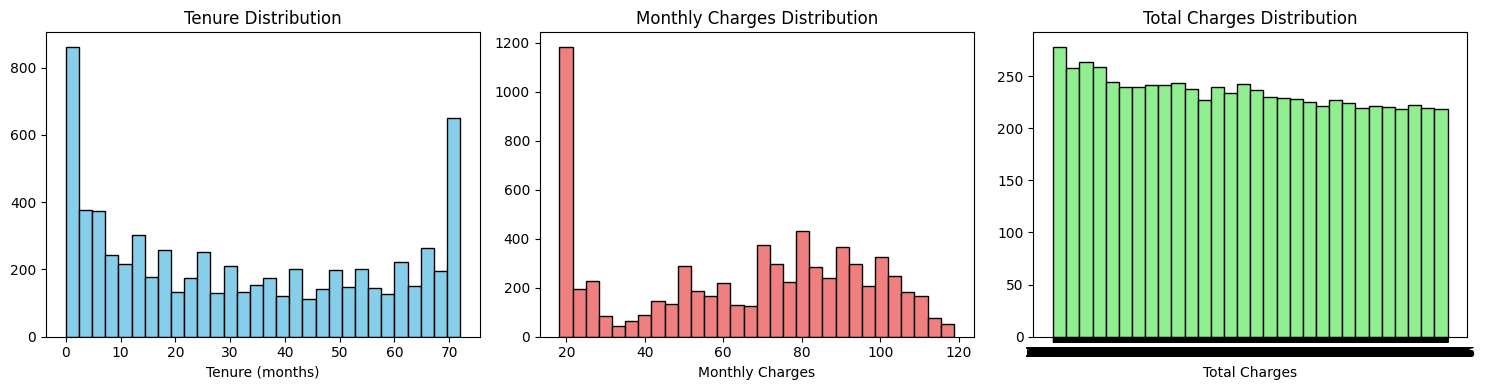

In [16]:
# distribusi numerical features
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].hist(df['tenure'], bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Tenure Distribution')
ax[0].set_xlabel('Tenure (months)')

ax[1].hist(df['MonthlyCharges'], bins=30, color='lightcoral', edgecolor='black')
ax[1].set_title('Monthly Charges Distribution')
ax[1].set_xlabel('Monthly Charges')

ax[2].hist(df['TotalCharges'], bins=30, color='lightgreen', edgecolor='black')
ax[2].set_title('Total Charges Distribution')
ax[2].set_xlabel('Total Charges')

plt.tight_layout()
plt.show()

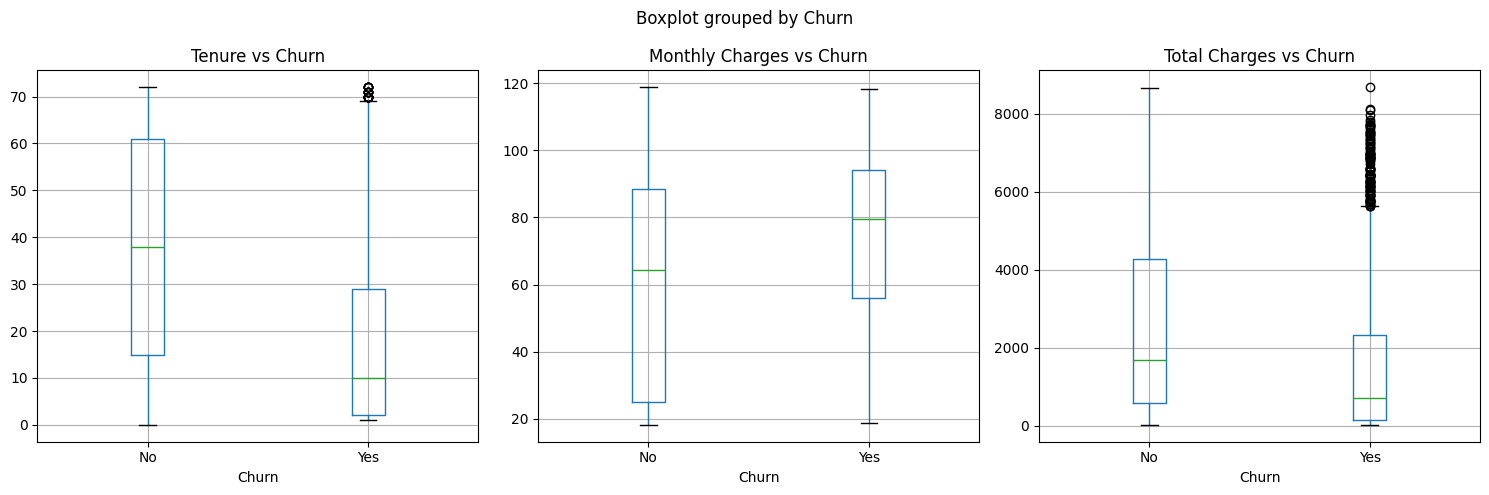

In [17]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

df.boxplot(column='tenure', by='Churn', ax=ax[0])
ax[0].set_title('Tenure vs Churn')
ax[0].set_xlabel('Churn')

df.boxplot(column='MonthlyCharges', by='Churn', ax=ax[1])
ax[1].set_title('Monthly Charges vs Churn')
ax[1].set_xlabel('Churn')

df.boxplot(column='TotalCharges', by='Churn', ax=ax[2])
ax[2].set_title('Total Charges vs Churn')
ax[2].set_xlabel('Churn')

plt.tight_layout()
plt.show()

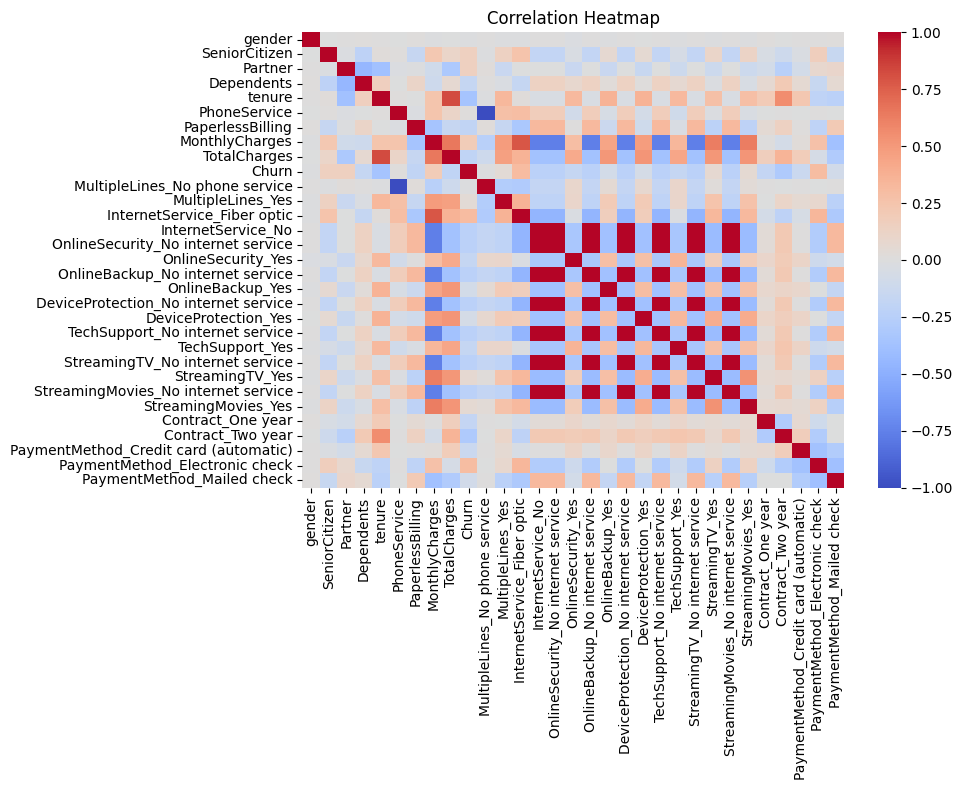

Top 10 correlations with Churn:
Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
SeniorCitizen                     0.150889
Partner                           0.150448
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
PhoneService                      0.011942
gender                           -0.008612
Name: Churn, dtype: float64


In [18]:
# correlation heatmap
plt.figure(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

# top correlations dengan churn
print("Top 10 correlations with Churn:")
print(corr['Churn'].sort_values(ascending=False).head(11))

## 4. Feature Selection

In [19]:
# information buat feature selection
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_train_sm, y_train_sm, random_state=42)
mi_series = pd.Series(mi, index=X_train_sm.columns).sort_values(ascending=False)

print("Top 15 features by Mutual Information:")
print(mi_series.head(15))

Top 15 features by Mutual Information:
tenure                                  0.278202
MonthlyCharges                          0.116007
Contract_Two year                       0.087915
PaymentMethod_Electronic check          0.074635
InternetService_Fiber optic             0.073434
TotalCharges                            0.051633
DeviceProtection_No internet service    0.042334
InternetService_No                      0.041883
StreamingTV_No internet service         0.041477
TechSupport_No internet service         0.041183
OnlineBackup_No internet service        0.039830
StreamingMovies_No internet service     0.039810
PaperlessBilling                        0.036176
Dependents                              0.035528
OnlineSecurity_No internet service      0.034725
dtype: float64


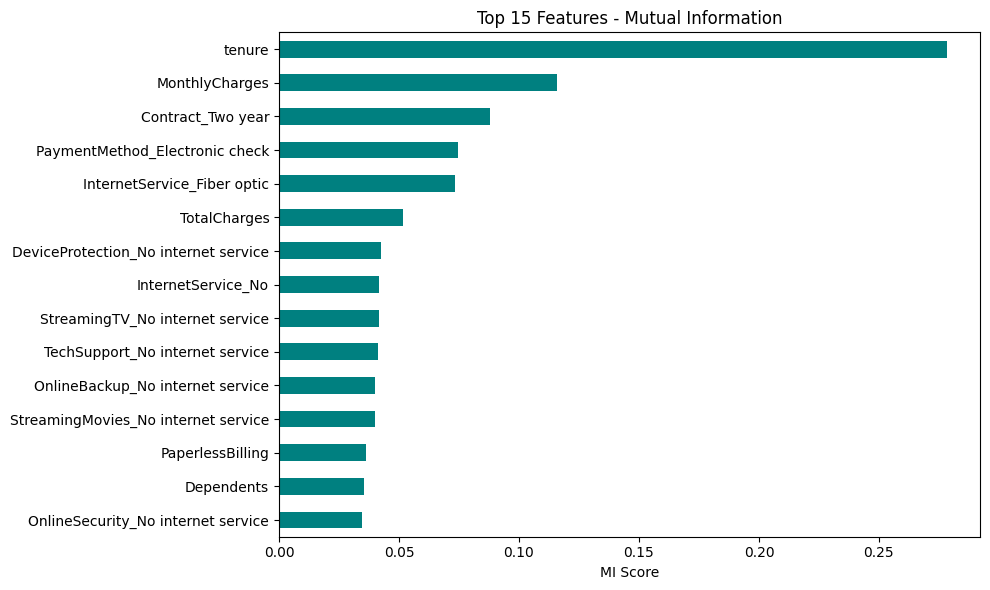

In [20]:
# plot top features
plt.figure(figsize=(10, 6))
mi_series.head(15).plot(kind='barh', color='teal')
plt.title('Top 15 Features - Mutual Information')
plt.xlabel('MI Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [21]:
# ambil top 15 features
top_features = mi_series.head(15).index.tolist()

X_train_sel = X_train_sm[top_features]
X_test_sel = X_test[top_features]

print(f"Selected features: {len(top_features)}")
print(f"Train shape: {X_train_sel.shape}")
print(f"Test shape: {X_test_sel.shape}")

Selected features: 15
Train shape: (8278, 15)
Test shape: (1409, 15)


## 5. Modeling

In [22]:
# Model 1: Logistic Regression
print("Training Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_sel, y_train_sm)

y_pred_lr = lr.predict(X_test_sel)
y_prob_lr = lr.predict_proba(X_test_sel)[:, 1]

print("Done!")

Training Logistic Regression...
Done!


In [23]:
# Model 2: Random Forest
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_sel, y_train_sm)

y_pred_rf = rf.predict(X_test_sel)
y_prob_rf = rf.predict_proba(X_test_sel)[:, 1]

print("Done!")

Training Random Forest...
Done!


In [24]:
# Model 3: XGBoost
print("Training XGBoost...")
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train_sel, y_train_sm)

y_pred_xgb = xgb.predict(X_test_sel)
y_prob_xgb = xgb.predict_proba(X_test_sel)[:, 1]

print("Done!")

Training XGBoost...
Done!


## 6. Evaluasi Model

In [25]:
# hitung metrics untuk semua model
def eval_model(y_true, y_pred, y_prob, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    return {
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': auc
    }

results = []
results.append(eval_model(y_test, y_pred_lr, y_prob_lr, 'Logistic Regression'))
results.append(eval_model(y_test, y_pred_rf, y_prob_rf, 'Random Forest'))
results.append(eval_model(y_test, y_pred_xgb, y_prob_xgb, 'XGBoost'))

results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print("="*70)
print(results_df.to_string(index=False))


Model Evaluation Results:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.733854   0.499130 0.767380  0.604847 0.826690
      Random Forest  0.732434   0.496788 0.620321  0.551724 0.790445
            XGBoost  0.741661   0.510549 0.647059  0.570755 0.799531


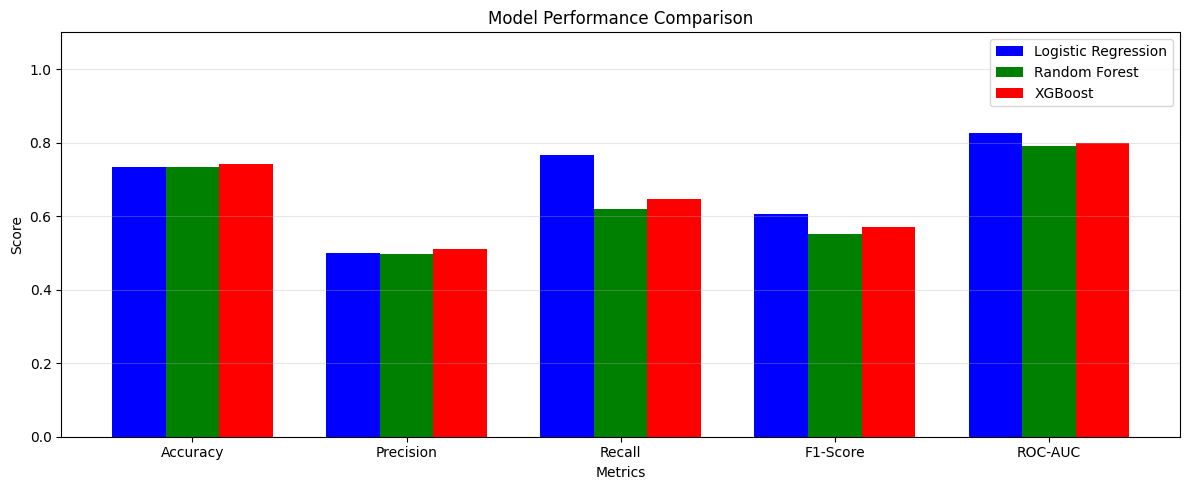

In [26]:
# plot comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 5))

lr_scores = results_df.iloc[0][metrics].values
rf_scores = results_df.iloc[1][metrics].values
xgb_scores = results_df.iloc[2][metrics].values

ax.bar(x - width, lr_scores, width, label='Logistic Regression', color='blue')
ax.bar(x, rf_scores, width, label='Random Forest', color='green')
ax.bar(x + width, xgb_scores, width, label='XGBoost', color='red')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

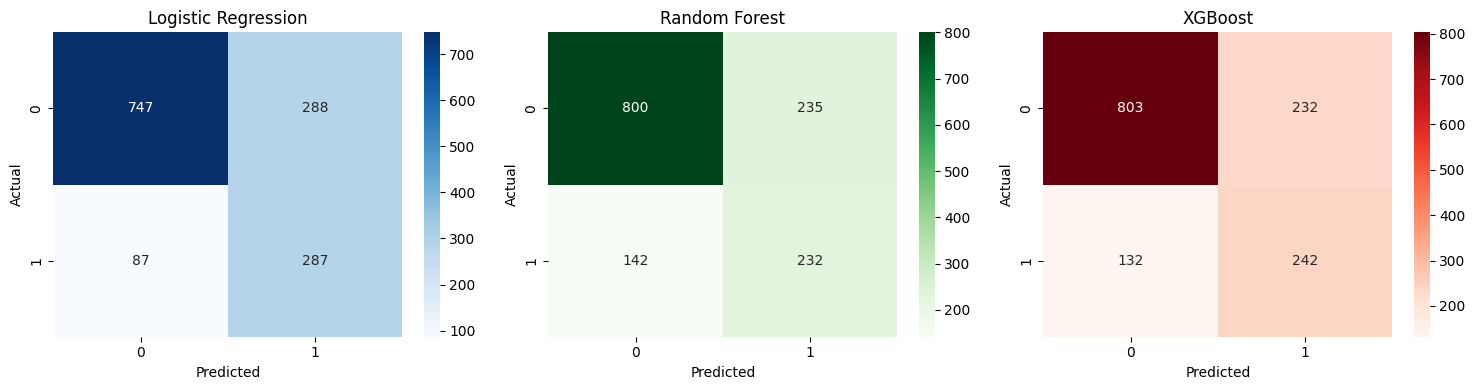

In [27]:
# confusion matrix
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Logistic Regression')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predicted')

sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Random Forest')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predicted')

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Reds', ax=ax[2])
ax[2].set_title('XGBoost')
ax[2].set_ylabel('Actual')
ax[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

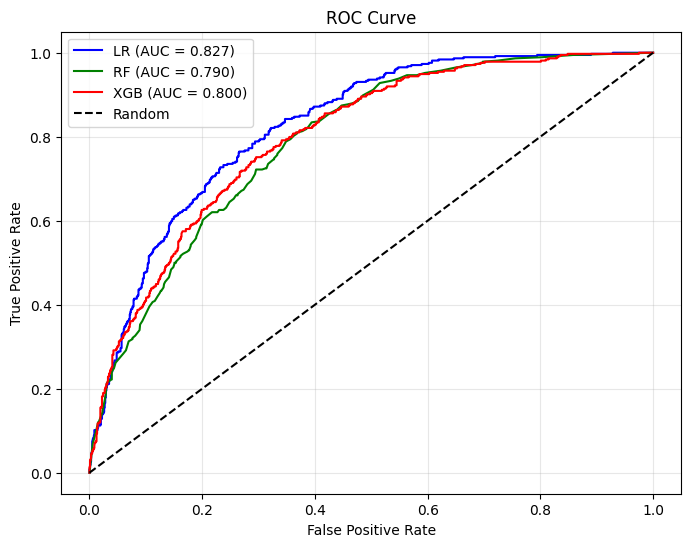

In [28]:
# ROC curve
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 6))

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {results_df.iloc[0]["ROC-AUC"]:.3f})', color='blue')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {results_df.iloc[1]["ROC-AUC"]:.3f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {results_df.iloc[2]["ROC-AUC"]:.3f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

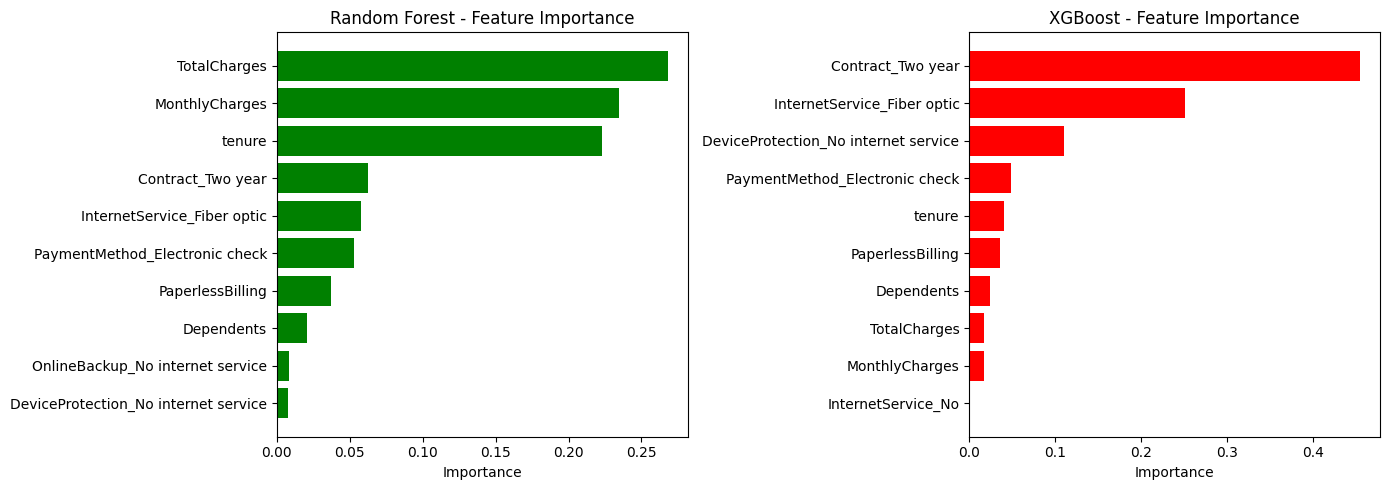

In [29]:
# feature importance dari RF dan XGB
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest
rf_imp = pd.DataFrame({
    'feature': top_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax[0].barh(rf_imp['feature'], rf_imp['importance'], color='green')
ax[0].set_xlabel('Importance')
ax[0].set_title('Random Forest - Feature Importance')
ax[0].invert_yaxis()

# XGBoost
xgb_imp = pd.DataFrame({
    'feature': top_features,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax[1].barh(xgb_imp['feature'], xgb_imp['importance'], color='red')
ax[1].set_xlabel('Importance')
ax[1].set_title('XGBoost - Feature Importance')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [30]:
# pilih best model berdasarkan F1-Score
best_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.iloc[best_idx]['Model']
best_f1 = results_df.iloc[best_idx]['F1-Score']

print("="*50)
print(f"Best Model: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
print("="*50)
print("\nFull metrics:")
print(results_df.iloc[best_idx])

Best Model: Logistic Regression
F1-Score: 0.6048

Full metrics:
Model        Logistic Regression
Accuracy                0.733854
Precision                0.49913
Recall                   0.76738
F1-Score                0.604847
ROC-AUC                  0.82669
Name: 0, dtype: object


## 7. Save Model

In [31]:
import joblib
import pickle
import os

# buat folder
os.makedirs('models', exist_ok=True)

# save models
joblib.dump(lr, 'models/logistic_regression.pkl')
joblib.dump(rf, 'models/random_forest.pkl')
joblib.dump(xgb, 'models/xgboost.pkl')

# save scaler
joblib.dump(scaler, 'models/scaler.pkl')

# save feature list
with open('models/features.pkl', 'wb') as f:
    pickle.dump(top_features, f)

# save results
results_df.to_csv('models/results.csv', index=False)

print("Models saved!")
print("Files:")
print("- logistic_regression.pkl")
print("- random_forest.pkl")
print("- xgboost.pkl")
print("- scaler.pkl")
print("- features.pkl")
print("- results.csv")

Models saved!
Files:
- logistic_regression.pkl
- random_forest.pkl
- xgboost.pkl
- scaler.pkl
- features.pkl
- results.csv


In [32]:
# test load model
model_test = joblib.load('models/random_forest.pkl')

# prediksi sample
sample = X_test_sel.iloc[:5]
pred = model_test.predict(sample)
prob = model_test.predict_proba(sample)

print("Test prediction:")
for i in range(5):
    print(f"Sample {i+1}: Pred={pred[i]}, Prob={prob[i][1]:.2f}, Actual={y_test.iloc[i]}")

Test prediction:
Sample 1: Pred=0, Prob=0.01, Actual=0
Sample 2: Pred=1, Prob=0.97, Actual=0
Sample 3: Pred=0, Prob=0.33, Actual=0
Sample 4: Pred=1, Prob=0.63, Actual=0
Sample 5: Pred=0, Prob=0.00, Actual=0
